In [1]:
%pip install ipykernel kafka-python pandas matplotlib folium python-dateutil ipython 

    100% |████████████████████████████████| 102kB 2.4MB/s a 0:00:011
    100% |████████████████████████████████| 61kB 7.5MB/s eta 0:00:01
branca 0.8.0 has requirement jinja2>=3, but you'll have jinja2 2.11.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
import logging
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, IFrame
import folium
from folium.plugins import MarkerCluster
import matplotlib.dates as mdates
from kafka import KafkaConsumer
import datetime
import time

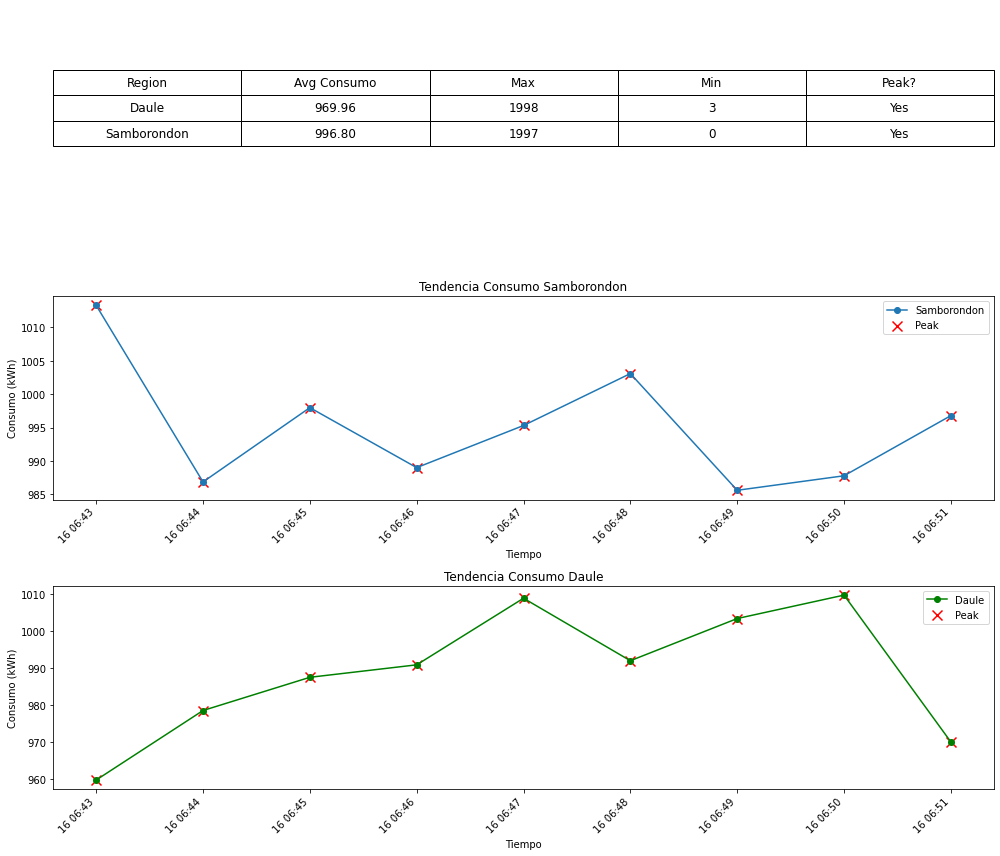

2024-12-16 06:51:28,597 - INFO - Received data: {'window_start': '2024-12-16T06:51:00.000Z', 'window_end': '2024-12-16T06:52:00.000Z', 'region': 'Daule', 'avg_consumo': 1001.4630769230769, 'max_consumo': 1999, 'min_consumo': 3, 'count_consumo': 650, 'is_peak': True}
2024-12-16 06:51:30,158 - INFO - Received data: {'window_start': '2024-12-16T06:51:00.000Z', 'window_end': '2024-12-16T06:52:00.000Z', 'region': 'Samborondon', 'avg_consumo': 995.8838461538462, 'max_consumo': 1997, 'min_consumo': 0, 'count_consumo': 1300, 'is_peak': True}


In [ ]:
import os
import json
import logging
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, IFrame
import folium
from folium.plugins import MarkerCluster
import matplotlib.dates as mdates
from kafka import KafkaConsumer
import datetime
import time

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Load medidores data if available
medidores_df = pd.DataFrame(columns=['id', 'region', 'lat', 'long'])
medidores_path = '/app/medidores.json'
if os.path.exists(medidores_path):
    try:
        with open(medidores_path, 'r') as f:
            medidores = json.load(f)
        medidores_df = pd.DataFrame(medidores)
        logger.info(f"Loaded {len(medidores_df)} medidores from {medidores_path}.")
    except Exception as e:
        logger.error(f"Error loading medidores.json: {e}")
else:
    logger.warning(f"{medidores_path} not found. Using empty medidores_df.")

# Kafka Consumer Configuration
consumer = KafkaConsumer(
    'output',
    bootstrap_servers='kafka:9092',
    auto_offset_reset='latest',
    group_id='visualization-group',
    value_deserializer=lambda m: json.loads(m.decode('utf-8')),
)

# Dictionary to store data keyed by (window_start, region)
data_dict = {}
MAX_RECORDS = 100

# Variable to track the last update time
last_update_time = time.time()
UPDATE_INTERVAL = 30  # seconds

def get_color_by_consumption(consumo):
    """Assign color based on average consumption."""
    if consumo is None:
        return 'blue'
    if consumo < 500:
        return 'green'
    elif consumo < 1000:
        return 'orange'
    else:
        return 'red'

def update_dashboard(df):
    # Clear the notebook output cell
    clear_output(wait=True)

    # Ensure window_start is datetime
    df['window_start'] = pd.to_datetime(df['window_start'], errors='coerce')
    df = df.dropna(subset=['window_start'])
    if df.empty:
        logger.warning("No valid data to visualize.")
        return

    # Get latest window and filter data for that window
    latest_window = df['window_start'].max()
    latest_data_window = df[df['window_start'] == latest_window]

    # Create Folium map if medidores_df is available
    map_html = None
    if not medidores_df.empty:
        avg_lat = medidores_df['lat'].mean()
        avg_long = medidores_df['long'].mean()
        m = folium.Map(location=[avg_lat, avg_long], zoom_start=12)
        marker_cluster = MarkerCluster().add_to(m)

        region_avg = latest_data_window.set_index('region')['avg_consumo'].to_dict()

        for _, medidor in medidores_df.iterrows():
            region = medidor['region']
            avg_consumo_region = region_avg.get(region)
            color = get_color_by_consumption(avg_consumo_region)
            popup_text = f"Region: {region}<br>"
            if avg_consumo_region is not None:
                popup_text += f"Avg. Consumo: {avg_consumo_region:.2f} kWh"
            else:
                popup_text += "Avg. Consumo: N/A"
            folium.CircleMarker(
                location=[medidor['lat'], medidor['long']],
                radius=8,
                color=color,
                fill=True,
                fill_color=color,
                popup=popup_text
            ).add_to(marker_cluster)

        map_html = 'map.html'
        m.save(map_html)

    # Split historical data by region
    historical_samborondon = df[df['region'] == 'Samborondon'].sort_values('window_start')
    historical_daule = df[df['region'] == 'Daule'].sort_values('window_start')

    # Create a new figure for each update
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))

    # (0) for map and indicators table
    ax_map = axes[0]
    ax_map.axis('off')

    if map_html:
        # Display map in the output cell (not in ax_map)
        display(IFrame(map_html, width='500', height='400'))
    
    ax_table = ax_map
    ax_table.axis('off')

    table_data = [['Region', 'Avg Consumo', 'Max', 'Min', 'Peak?']]
    for _, row in latest_data_window.iterrows():
        peak_str = 'Yes' if row['is_peak'] else 'No'
        table_data.append([
            row['region'],
            f"{row['avg_consumo']:.2f}",
            row['max_consumo'],
            row['min_consumo'],
            peak_str
        ])

    tbl = ax_table.table(cellText=table_data, loc='center', cellLoc='center')
    tbl.set_fontsize(12)
    tbl.scale(1, 2)

    # Set up a more automatic locator/formatter for times
    locator = mdates.AutoDateLocator()
    formatter = mdates.AutoDateFormatter(locator)

    # (1) Samborondon Trend
    ax_sam = axes[1]
    ax_sam.clear()
    if not historical_samborondon.empty:
        ax_sam.plot(historical_samborondon['window_start'], historical_samborondon['avg_consumo'], marker='o', label='Samborondon')
        sam_peaks = historical_samborondon[historical_samborondon['is_peak']]
        if not sam_peaks.empty:
            ax_sam.scatter(sam_peaks['window_start'], sam_peaks['avg_consumo'], color='red', marker='x', s=100, label='Peak')
        ax_sam.set_title('Tendencia Consumo Samborondon')
        ax_sam.set_xlabel('Tiempo')
        ax_sam.set_ylabel('Consumo (kWh)')

        ax_sam.xaxis.set_major_locator(locator)
        ax_sam.xaxis.set_major_formatter(formatter)

        plt.setp(ax_sam.get_xticklabels(), rotation=45, ha='right')
        ax_sam.legend()
    else:
        ax_sam.text(0.5, 0.5, 'No Data Samborondon', ha='center', va='center')

    # (2) Daule Trend
    ax_dau = axes[2]
    ax_dau.clear()
    if not historical_daule.empty:
        ax_dau.plot(historical_daule['window_start'], historical_daule['avg_consumo'], marker='o', color='green', label='Daule')
        dau_peaks = historical_daule[historical_daule['is_peak']]
        if not dau_peaks.empty:
            ax_dau.scatter(dau_peaks['window_start'], dau_peaks['avg_consumo'], color='red', marker='x', s=100, label='Peak')
        ax_dau.set_title('Tendencia Consumo Daule')
        ax_dau.set_xlabel('Tiempo')
        ax_dau.set_ylabel('Consumo (kWh)')

        ax_dau.xaxis.set_major_locator(locator)
        ax_dau.xaxis.set_major_formatter(formatter)

        plt.setp(ax_dau.get_xticklabels(), rotation=45, ha='right')
        ax_dau.legend()
    else:
        ax_dau.text(0.5, 0.5, 'No Data Daule', ha='center', va='center')

    plt.tight_layout()
    display(fig)
    plt.close(fig)

try:
    logger.info("Starting data consumption loop...")
    while True:
        message_pack = consumer.poll(timeout_ms=1000, max_records=10)
        if not message_pack:
            # If no messages, check if it's time to update the dashboard
            current_time = time.time()
            if (current_time - last_update_time) >= UPDATE_INTERVAL:
                # Update the dashboard if we have data
                if data_dict:
                    df = pd.DataFrame(data_dict.values())
                    update_dashboard(df)
                    last_update_time = current_time
            continue

        # Process incoming messages
        updated = False
        for tp, messages in message_pack.items():
            for message in messages:
                data = message.value
                logger.info(f"Received data: {data}")

                required_fields = ['window_start', 'window_end', 'region', 'avg_consumo', 'max_consumo', 'min_consumo', 'is_peak']
                if not all(field in data for field in required_fields):
                    logger.error(f"Incomplete data received: {data}")
                    continue

                # Use (window_start, region) as the key to avoid duplicates
                key = (data['window_start'], data['region'])
                data_dict[key] = {
                    'window_start': data['window_start'],
                    'window_end': data['window_end'],
                    'region': data['region'],
                    'avg_consumo': data['avg_consumo'],
                    'max_consumo': data['max_consumo'],
                    'min_consumo': data['min_consumo'],
                    'is_peak': data['is_peak']
                }
                updated = True

        # Keep only the last MAX_RECORDS entries if needed
        if len(data_dict) > MAX_RECORDS:
            # sort by window_start
            sorted_keys = sorted(data_dict.keys(), key=lambda x: x[0])
            while len(data_dict) > MAX_RECORDS:
                oldest_key = sorted_keys.pop(0)
                del data_dict[oldest_key]

        # After processing this batch, check if 30 seconds have passed since last update
        current_time = time.time()
        if (current_time - last_update_time) >= UPDATE_INTERVAL:
            if data_dict:
                df = pd.DataFrame(data_dict.values())
                update_dashboard(df)
            last_update_time = current_time

except KeyboardInterrupt:
    logger.info("Visualization stopped by user.")
finally:
    consumer.close()
    logger.info("Kafka consumer closed.")